# pySCENIC on NK cells, MM

Preparation and run Single-Cell rEgulatory Network Inference and Clustering using pySCENIC.

## Why pySCENIC
- A lot of compatibility problems with the R version
- Faster
- I like more python than

After having preparred the environment and the files (look [here](./prepare_env.ipnb))

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [9]:
adata = sc.read_h5ad("Data/mm_nk.h5ad")
adata

AnnData object with n_obs × n_vars = 14103 × 48361
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'label', 'new_label', 'condition'

In [3]:
#sc.pp.subsample(adata, n_obs=100)

write to an unfiltered loom file

In [4]:
f_loom_path_unfilt = "Data/nk_mm_unfiltered.loom"
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    "new_label": np.array(adata.obs.new_label)
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

# basic metrics and filtering:

In [10]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info~
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3303925.0
Number of cells in which each gene is detected: 0  -  14081


In [11]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  423.09
minSamples:  141.03


In [12]:
adata_copy = adata.copy()

# initial cuts
sc.pp.filter_cells(adata_copy, min_genes=200 )
sc.pp.filter_genes(adata_copy, min_cells=minSamples)
sc.pp.filter_genes(adata_copy, min_counts=minCountsPerGene)

adata_copy

AnnData object with n_obs × n_vars = 14038 × 8095
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'label', 'new_label', 'condition', 'n_genes'
    var: 'n_cells', 'n_counts'

In [19]:
f_loom_path_scenic = "Data/nk_mm_scenic.loom"

In [8]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

## Scenic


### STEP 1: Gene regulatory network inference, and generation of co-expression modules
Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used.


In [23]:
tfs = "databases/allTFs_hg38.txt"

In [10]:
!mkdir Results

Dask is having memoru issues using all the cores available (24), testing with less nodes (12) ([reference](https://github.com/aertslab/pySCENIC/issues/54#issuecomment-817164063)). If it doesn't work I'll try the multiprocessing script:
```
! arboreto_with_multiprocessing.py \
    {f_loom_path_scenic} \
    {tfs} \
    --method grnboost2 \
    --output Results/adj.tsv \
    --num_workers 24 \
    --seed 123
```

`pyscenic grn` with less workers worked (half of the cpus available)

In [14]:
!pyscenic grn {f_loom_path_scenic} {tfs} -o Results/adj.csv --num_workers 12 --seed 123 1> grn.log 2> grn.err

In [3]:
adjacencies = pd.read_csv("Results/adj.csv", index_col=False, sep='\t')
adjacencies.head()

,"TF,target,importance"
0,"ZNF90,AC090498.1,291.6007153679469"
1,"RPL35,RPL27A,277.3820707232509"
2,"TPI1,ENO1,246.19201133992507"
3,"ZNF90,GNB2L1,234.80202042156603"
4,"RPL35,RPL13A,229.1613366803689"


In [24]:
import glob
# ranking databases
f_db_glob = "databases/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "databases/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl"

Evaluate co-expressio modules infering TF motifs:

In [26]:
!pyscenic ctx Results/adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output Results/reg.csv \
    --mask_dropouts \
    --num_workers 24 \
    1> ctx.log 2> ctx.err

In [27]:
nGenesDetectedPerCell = pd.DataFrame(np.sum(adata_copy.X>0, axis=1).flatten().tolist()).T
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

           0
0.01   264.0
0.05   396.0
0.10   525.0
0.50  1036.0
1.00  4681.0


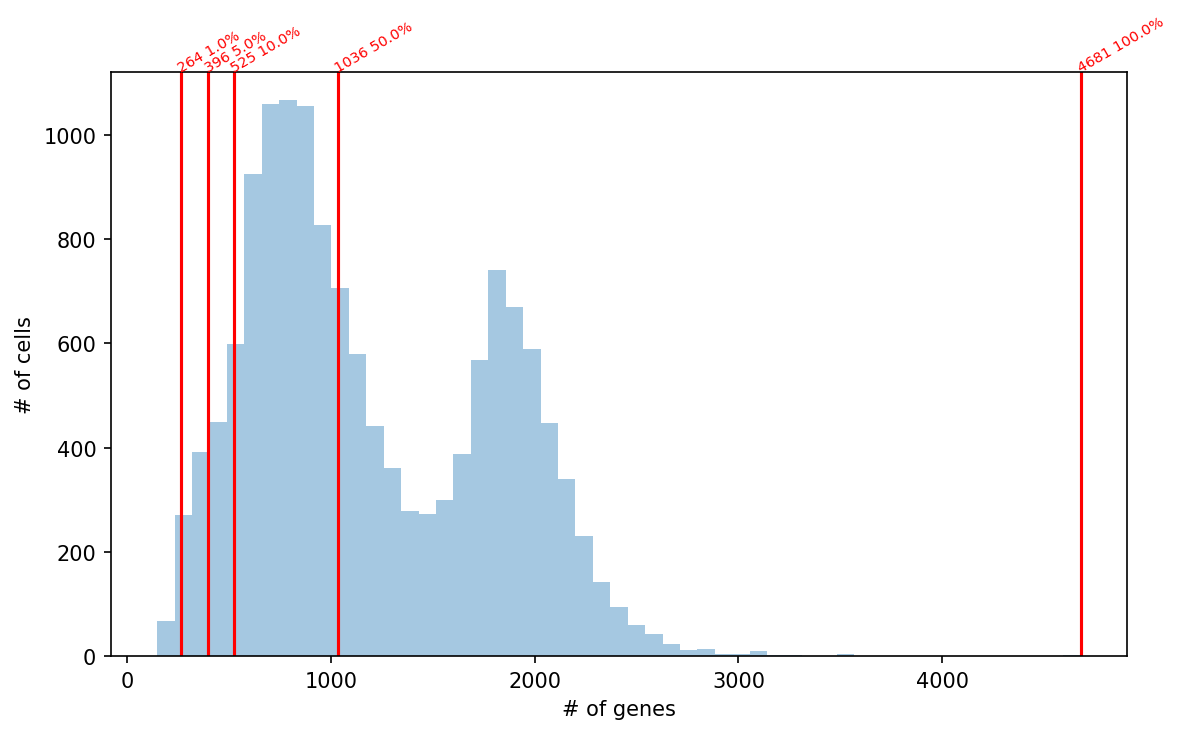

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in percentiles.iterrows():
    fig.gca().axvline(x=x[0], ymin=0,ymax=1, color='red')
    ax.text(x=x[0], y=ax.get_ylim()[1], s=f'{int(x[0])} {i*100}%', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [29]:
f_pyscenic_output = "Results/pyscenic_output.loom"

In [31]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    Results/reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 24 \
     1> aucell.log 2> aucell.err

In [32]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [33]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')

In [34]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
###

In [35]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

# TODO: continue with saving the file, adding the umap coordinates to the anndata object, analysis

In [44]:
adata_copy

AnnData object with n_obs × n_vars = 14038 × 8095
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'label', 'new_label', 'condition', 'n_genes'
    var: 'n_cells', 'n_counts'

In [45]:
dr_umap.shape

(14103, 2)